# Model module tutorial

This tutorial is a part of Model module guide. Here, we explore how you can use the FilteringModel wrapper to use your Python or Matlab filtering functions in the benchmark.

In [15]:
# If you are executing this notebook at a location different than root, you need to add it to
# the path.
import os
import sys
sys.path.insert(0,'../../')

In [2]:
# Python packages
import gc
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

In [3]:
# Matlab engine
try:
    import matlab.engine
except ImportError as err:
    print(err)

# Matlab engine
eng = matlab.engine.start_matlab()

In [4]:
def display_results(clean_imgs, noisy_imgs, rest_images, name):
    """Display denoising results."""
    fig, axes = plt.subplots(5, 3, figsize=(15, 15))
    
    plt.suptitle("Denoising results using {}".format(name))

    for i in range(5):
        axes[i, 0].imshow(np.squeeze(clean_imgs[i]), cmap="gray")
        axes[i, 0].axis("off")
        axes[i, 0].set_title("Ground-Truth")

        axes[i, 1].imshow(np.squeeze(noisy_imgs[i]), cmap="gray")
        axes[i, 1].axis("off")
        axes[i, 1].set_title("Noised Image")

        axes[i, 2].imshow(np.squeeze(rest_imgs[i]), cmap="gray")
        axes[i, 2].axis("off")
        axes[i, 2].set_title("Restored Images")

In [9]:
from OpenDenoising import data
from OpenDenoising import model

W0902 10:54:21.869839 140070157895488 deprecation_wrapper.py:119] From ../../model/tf_model.py:15: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



In [6]:
data.download_BSDS_grayscale(output_dir="../../tmp/BSDS500/")

Using TensorFlow backend.


In [7]:
# Validation images generator
valid_generator = data.DatasetFactory.create(path="../../tmp/BSDS500/Valid",
                                             batch_size=8,
                                             n_channels=1,
                                             noise_config={data.utils.gaussian_noise: [25]},
                                             name="BSDS_Valid")

# FilteringModel <a class="anchor" id="filtering-model"></a>
---

To define a filtering model, you need either a Python or Matlab function that performs the denoising.

# Navigation
---

* [Using a Python-based function for Image Denoising.](#filtering-with-python-funcs)
* [Using a Matlab-based function for Image Denoising.](#filtering-with-matlab-funcs)
    * [Provide your own Matlab functions.](#including-your-matlab-funcs)

## Using a Python-based function for Image Denoising. <a class="anchor" id="filtering-with-python-funcs"></a>

Python-based functions should agree with the following convention:

```Python
def my_filter(image, optional_arguments):
    # Perform the filter algorithm
    return restored_image
```

where image is a 4D numpy ndarray, and restored_image is a 4D numpy ndarray with same shape as image. As an example, consider the median_filter implemented on model.filtering,

```Python
def median_filter(image, filter_size=(3, 3), stride=(1, 1)):
    """Naive implementation of median filter using numpy.

    Parameters
    ----------
    image : :class:`numpy.ndarray`
        4D batch of noised images. It has shape: (batch_size, height, width, channels).
    filter_size : list
        2D list containing the size of filter's kernel.
    stride : list
        2D list containing the horizontal and vertical strides.

    Returns
    -------
    output : :class:`numpy.ndarray`
        4D batch of denoised images. It has shape: (batch_size, height, width, channels).
    """
    if image.ndim == 2:
        image = np.expand_dims(np.expand_dims(image, axis=0), axis=-1)
    p = filter_size[0] // 2
    sh, sw = stride

    _image = np.pad(image, pad_width=((0, 0), (p, p), (p, p), (0, 0)), mode="constant")
    N, h, w, c = _image.shape
    output = np.zeros(image.shape)

    for i in range(p, h - p, sh):
        # Loops over horizontal axis
        for j in range(p, w - p, sw):
            # Loops over vertical axis
            window = _image[:, i - p: i + p, j - p: j + p, :]
            output[:, i - p, j - p, :] = np.median(window, axis=(1, 2))

    return output
```

In [10]:
filt1 = model.FilteringModel(model_name="Median_filter")
# Note: optinal arguments may be passed to charge_model via **kwargs
filt1.charge_model(model_function=model.filtering.median_filter, filter_size=(7, 7), stride=(1, 1))

## Using a Matlab-based function for Image Denoising. <a class="anchor" id="filtering-with-matlab-funcs"></a>

You can also use Matlab functions to perform image denoising. To do so, you need to wrap your Matlab function with a Python function. As an example, consider the [BM3D matlab's implementation](http://www.cs.tut.fi/~foi/GCF-BM3D/). You can download the author's code, and place it into "./matlab_libs/bm3dlib". As an example of function wrapping matlab's code, consider the following:

```Python
def BM3D(z, sigma=25.0, profile="np", channels_first=False):
    """This function wraps MATLAB's BM3D implementation, available on matlab_libs/BM3Dlib. The original code is
    available to the public through the author's page, on http://www.cs.tut.fi/~foi/GCF-BM3D/

    Parameters
    ----------
    z : :class:`numpy.ndarray`
        4D batch of noised images. It has shape: (batch_size, height, width, channels).
    sigma : float
        Level of gaussian noise.
    profile : str
        One between {'np', 'lc', 'high', 'vn', 'vn_old'}. Algorithm's profile.

        Available for grayscale:

        * 'np': Normal profile.
        * 'lc': Fast profile.
        * 'high': High quality profile.
        * 'vn': High noise profile (sigma > 40.0)
        * 'vn_old': old 'vn' profile. Yields inferior results than 'vn'.

        Available for RGB:

        * 'np': Normal profile.
        * 'lc': Fast profile.

    Returns
    -------
    y_est : :class:`numpy.ndarray`
        4D batch of denoised images. It has shape: (batch_size, height, width, channels).
    """
    _z = z.copy()
    rgb = True if _z.shape[-1] == 3 else False
    if rgb:
        assert (profile in ["np", "lc", "high", "vn", "vn_old"]), "Expected profile to be 'np', 'lc', 'high', 'vn' " \
                                                                  "or 'vn_old' but got {}.".format(profile)
    else:
        assert (profile in ["np", "lc"]), "Expected profile to be 'np', 'lc' bug got {}".format(profile)


    # Convert input arrays to matlab
    m_sigma = matlab.double([sigma])
    m_show = matlab.int64([0])

    # Call BM3D function on matlab
    y_est = []
    for i in range(len(_z)):
        m_z = matlab.double(_z[i, :, :, :].tolist())
        if rgb:
            _, y_est = eng.CBM3D(m_z, m_z, m_sigma, profile, m_show, nargout=2)
        else:
            _, y = eng.BM3D(m_z, m_z, m_sigma, profile, m_show, nargout=2)
        y_est.append(np.asarray(y))

    y_est = np.asarray(y_est).reshape(z.shape)
    return y_est
```

Here, we make a few remarks,

* You need your engine to be defined in order to call the Matlab function.
* Inside the Python's matlab module, you have a series of classes making the bridge between Python and Matlab variables. Moreover, Python does not handle so well operations between these classes (for instance, the addition between two matlab.double variables). A way to get around this, is to do all operations inside of Matlab's functions. Therefore, your Python wrapper function should prepare the arguments to be passed to your Matlab function, followed by a call "eng.my_matlab_function".
* If your matlab function returns more than one argument, you need to specify the "nargout" parameter (even if it is not present in your Matlab code).
* After Matlab done its computation, it outputs "Matlab arrays". These can be converted into numpy arrays by calling "numpy.asarray" function.

In [11]:
filt2 = model.FilteringModel(model_name="BM3D_filter")
filt2.charge_model(model_function=model.filtering.BM3D, sigma=25.0, profile="np")

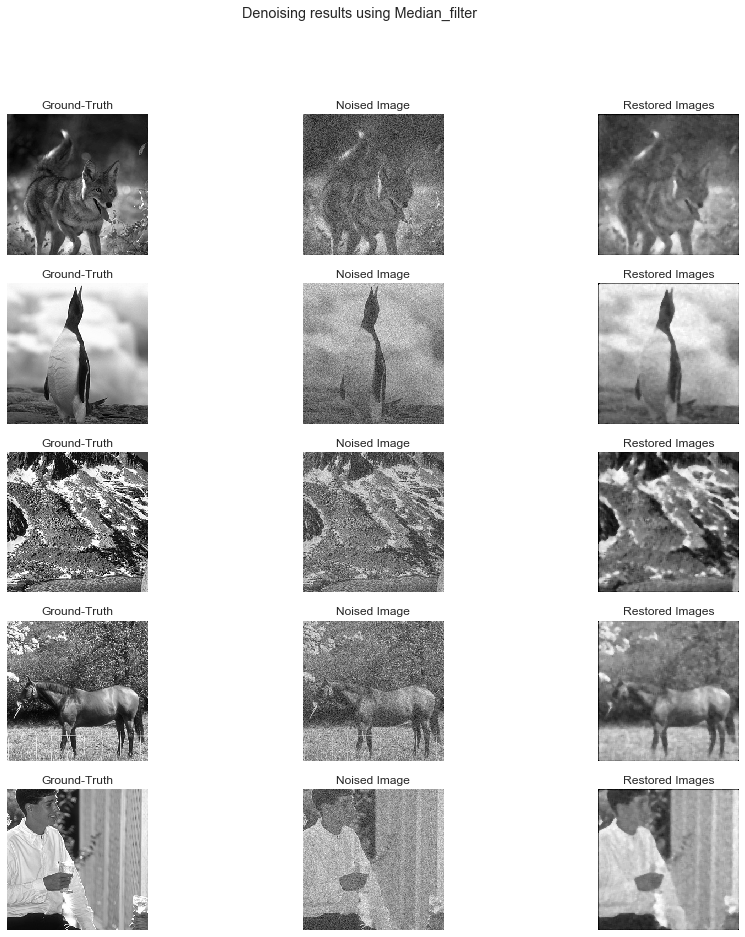

In [12]:
# Get batch from generator
noisy_imgs, clean_imgs = next(valid_generator)
# Performs inference on noisy images
rest_imgs = filt1(noisy_imgs)
display_results(clean_imgs, noisy_imgs, rest_imgs, str(filt1))

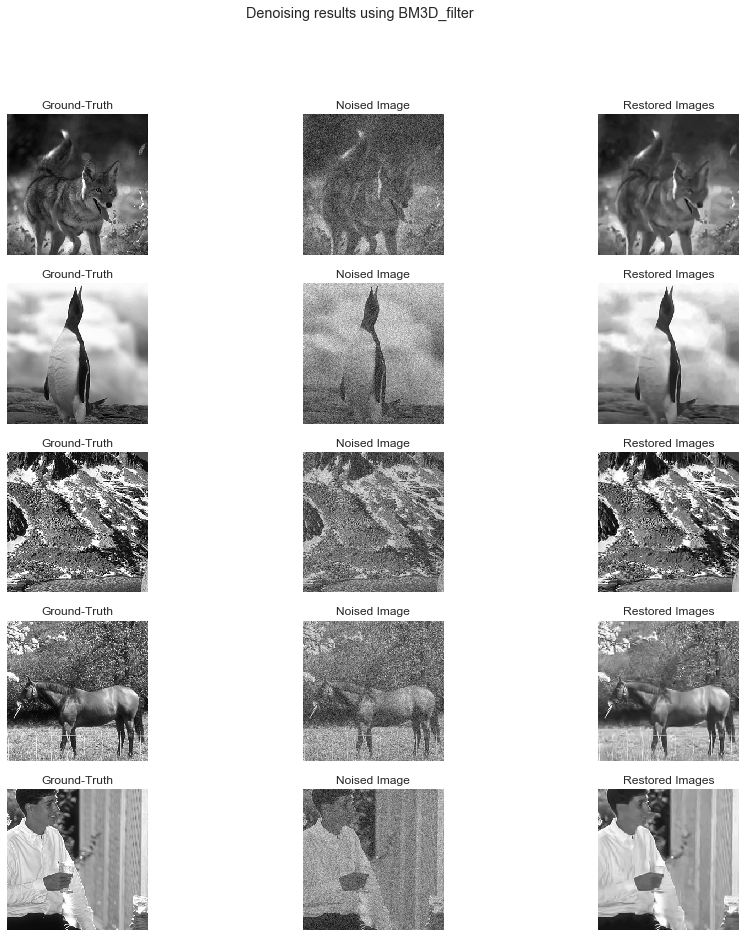

In [13]:
# Get batch from valid_generator
noisy_imgs, clean_imgs = next(valid_generator)
# Performs inference on noisy images
rest_imgs = filt2(noisy_imgs)
display_results(clean_imgs, noisy_imgs, rest_imgs, str(filt2))

#### Provide your own Matlab functions. <a class="anchor" id="including-your-matlab-funcs"></a>

Consider one more example of how you can include Matlab functions into your FilteringModels. We define a script for a function called "kernel_filter" in the folder "./Examples/Jupyter Notebooks/Additional Files". The Matlab function has the following implementation:

```Matlab
function y_est = kernel_filter(z, kernel)

k = size(kernel);
k = floor(k(1) / 2);
ndims = length(size(z));
y_est = zeros(size(z));

if ndims == 2
    z_ = padarray(z, [k, k], 0, 'both');
    [N, h, w, c] = size(z_);
    for i=k+1:h
        for j=k+1:w
            window = sum(z_(i-k:i+k, j-k:j+k) .* kernel, 'all');
            y_est(n, i - k, j - k) = window;
        end
    end
else
    z_ = padarray(z, [k, k, 0], 0, 'both');
    [N, h, w, c] = size(z_);
    kernel = repmat(kernel, [1, 1, 3]);
    for i=k+1:h-k
        for j=k+1:w-k
            window = sum(sum(z_(i-k:i+k, j-k:j+k, :) .* kernel));
            y_est(i - k, j - k, :) = window;
        end
    end
end

```

As we can see, this function denoises one single image at time, so the 4D-in 4D-out convention needs to be handled in the Python wrapper function. Then, you can verify that the function is indeed on your Matlab's path by executing:

In [16]:
eng.addpath(os.path.abspath("./Additional Files/"))
print(eng.which("kernel_filter"))

/home/efernand/repos/Summer_Internship_2019/Code/examples/Jupyter Notebooks/Additional Files/kernel_filter.m


In [17]:
def kernel_filter_wrapper(image, kernel):
    """Naive implementation of spatial filtering with numpy.

    Parameters
    ----------
    image : :class:`numpy.ndarray`
        4D batch of noised images. It has shape: (batch_size, height, width, channels).
    kernel : :class:`numpy.ndarray`
        2D filter to be convolved with each image in the batch.

    Returns
    -------
    y_est : :class:`numpy.ndarray`
        4D batch of denoised images. It has shape: (batch_size, height, width, channels).
    """
    m_kernel = matlab.double(kernel.tolist()) # Converts Kernel to Matlab double class.
    y_est = [] # List of outputs
    for i in range(len(image)):
        m_image = matlab.double(image[i].tolist()) # Converts i-th image to Matlab double class.
        # Note: matlab.double class only accepts lists as inputs, so you need to call .tolist() in your numpy arrays.
        y = eng.kernel_filter(m_image, m_kernel) # Calls matlab "kernel_filter" with inputs m_image and m_kernel
        y_est.append(np.asarray(y)) # Appends Matlab's output as numpy array
    y_est = np.asarray(y_est).reshape(image.shape) # Converts list of outputs into array.
    return y_est

In [18]:
kernel = np.ones([5, 5]) / 25 # Mean filter kernel

filt3 = model.FilteringModel(model_name="kernel_filter")
filt3.charge_model(model_function=kernel_filter_wrapper, kernel=kernel)

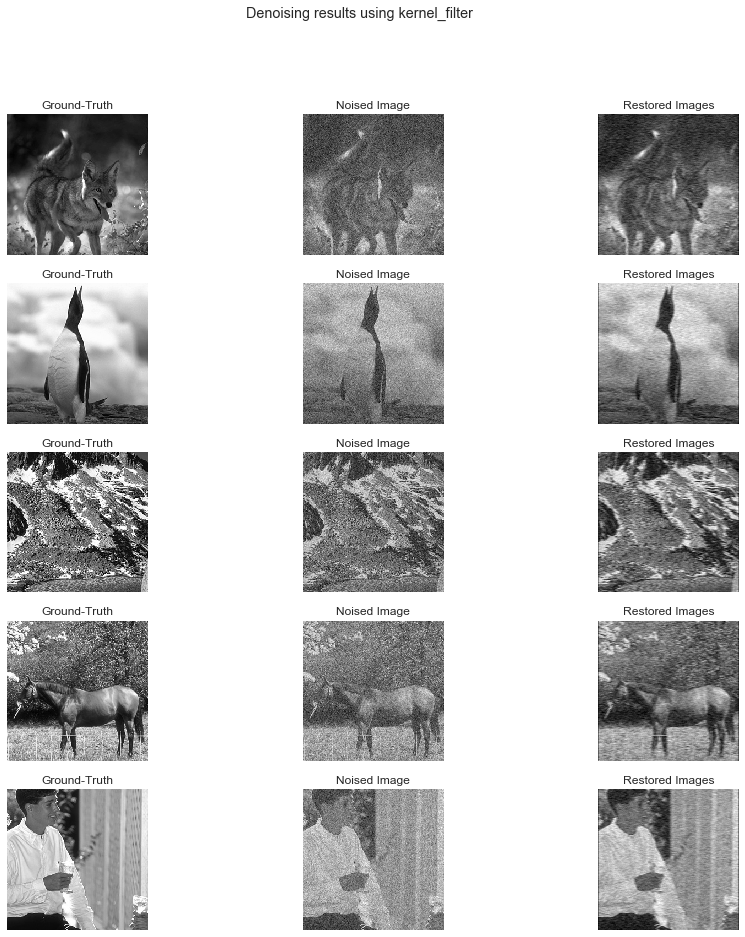

In [19]:
# Get batch from valid_generator
noisy_imgs, clean_imgs = next(valid_generator)
# Performs inference on noisy images
rest_imgs = filt3(noisy_imgs)
display_results(clean_imgs, noisy_imgs, rest_imgs, str(filt3))